In [108]:
import pandas as pd
df = pd.DataFrame()
import csv
from scipy.stats import zscore
import numpy as np
import datetime as dt

### Input data that can't be extracted

In [109]:
# log month represents the month in the log file: 1 = January, 2 = February, etc.
log_month = 9
# log day represents the day in the log file: 1 = 1st, 2 = 2nd, etc.
log_day = 20
# log year represents the year in the log file: 2018, 2019, etc.
log_year = 2021

### do not change below this line ###
# Calcuate the day name of the date
log_day_name = dt.datetime(log_year, log_month, log_day)
log_day_name = log_day_name.strftime("%A")
print(log_day_name)
### do not change above line ###


Monday


## Extract data from raw text wifi log file

In [110]:
#Create csv file
jan1_csv = open('jan1.csv', 'w')
#Column names
col_name = ['building', 'time', 'device_count']
csv_writer = csv.DictWriter(jan1_csv, fieldnames=col_name)
csv_writer.writeheader()

28

In [111]:
def processLine(buildingName='UREC', wifi_log=''):
    count = 0
    for log_line in wifi_log:
        if buildingName in log_line:
            # process device count
            if '501080' in log_line or '501105' in log_line or '501106' in log_line:
                count += 0
            if '501093' in log_line:
                count += 1
            # Slice the line to get the date and time
            atr = log_line.split(' ')
            # Extract the data
            # month = 0
            # day = 0
            # day_name = ''
            time = atr[2]
            building = buildingName
            # add data to csv file
            csv_writer.writerow({'building': building,'time': time, 'device_count': count})


In [112]:
wifi_log = open('wireless_09-20-2021.log', 'r')
# # print first ten lines in the file
# for i in range(3):
#     print(wifi_log.readline())

# loop through each line in the file
processLine(wifi_log=wifi_log)

# close the file
wifi_log.close()


# Preprocess the raw csv to something meaningful (non-scalable)

### Look at the dataframe

In [113]:
# Look look at the data
# convert jan1.csv to dataframe
df = pd.read_csv('jan1.csv')
df

,building,time,device_count
0,UREC,00:00:04,1
1,UREC,00:00:04,1
2,UREC,00:00:04,1
3,UREC,00:00:04,1
4,UREC,00:00:04,1
...,...,...,...
1032723,UREC,23:58:48,168045
1032724,UREC,23:58:51,168045
1032725,UREC,23:58:51,168045
1032726,UREC,23:58:54,168045


### Process the day_name, to reflect the data properly

In [114]:
df['day_name'] = log_day_name
df['month'] = log_month
df['day'] = log_day
df['year'] = log_year
df

,building,time,device_count,day_name,month,day,year
0,UREC,00:00:04,1,Monday,9,20,2021
1,UREC,00:00:04,1,Monday,9,20,2021
2,UREC,00:00:04,1,Monday,9,20,2021
3,UREC,00:00:04,1,Monday,9,20,2021
4,UREC,00:00:04,1,Monday,9,20,2021
...,...,...,...,...,...,...,...
1032723,UREC,23:58:48,168045,Monday,9,20,2021
1032724,UREC,23:58:51,168045,Monday,9,20,2021
1032725,UREC,23:58:51,168045,Monday,9,20,2021
1032726,UREC,23:58:54,168045,Monday,9,20,2021


### Process the time columns into a timestamp column

In [115]:
# convert time, day, month, year to datetime
df['timestamp']=df[['year','month','day']].astype(str).apply('-'.join,1)+' '+df['time']
df['timestamp'] = pd.to_datetime(df['timestamp'])
# df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'time']])
# get type of time column
print('timestamp column type: ', df['timestamp'].dtype)
df

timestamp column type:  datetime64[ns]


,building,time,device_count,day_name,month,day,year,timestamp
0,UREC,00:00:04,1,Monday,9,20,2021,2021-09-20 00:00:04
1,UREC,00:00:04,1,Monday,9,20,2021,2021-09-20 00:00:04
2,UREC,00:00:04,1,Monday,9,20,2021,2021-09-20 00:00:04
3,UREC,00:00:04,1,Monday,9,20,2021,2021-09-20 00:00:04
4,UREC,00:00:04,1,Monday,9,20,2021,2021-09-20 00:00:04
...,...,...,...,...,...,...,...,...
1032723,UREC,23:58:48,168045,Monday,9,20,2021,2021-09-20 23:58:48
1032724,UREC,23:58:51,168045,Monday,9,20,2021,2021-09-20 23:58:51
1032725,UREC,23:58:51,168045,Monday,9,20,2021,2021-09-20 23:58:51
1032726,UREC,23:58:54,168045,Monday,9,20,2021,2021-09-20 23:58:54


In [116]:
# testing
# query the row between 00:00:00 and 00:00:59
# df.query('timestamp >= "2021-09-20 00:00:00" and timestamp <= "2021-09-20 00:00:59"')

In [117]:
count = 0
dfTrim = pd.DataFrame()
df1 = pd.DataFrame()

while count < 24:
    startTime = ''
    endTime = ''

    if count < 10:
        # add log_day, log_month, log_year, and time to the start and end time
        startTime = str(log_year) + '-' + str(log_month) + '-' + str(log_day) + ' 0' + str(count) + ':00:00'
        startTime= pd.to_datetime(startTime)
        endTime = str(log_year) + '-' + str(log_month) + '-' + str(log_day) + ' 0' + str(count) + ':59:59'
        endTime = pd.to_datetime(endTime)
    else:
        startTime = str(log_year) + '-' + str(log_month) + '-' + str(log_day) + ' ' + str(count) + ':00:00'
        startTime= pd.to_datetime(startTime)
        endTime = str(log_year) + '-' + str(log_month) + '-' + str(log_day) + ' ' + str(count) + ':59:59'
        endTime = pd.to_datetime(endTime)
    # loc the rows between the start and end time
    df1 = df.loc[(df['timestamp'] >= startTime) & (df['timestamp'] <= endTime)]
    # contact the first row of df1 to dfTrim
    dfTrim = pd.concat([dfTrim, df1.head(1)])
    count += 1


dfTrim = dfTrim.reset_index()
dfTrim


,index,building,time,device_count,day_name,month,day,year,timestamp
0,0,UREC,00:00:04,1,Monday,9,20,2021,2021-09-20 00:00:04
1,1292,UREC,01:00:15,222,Monday,9,20,2021,2021-09-20 01:00:15
2,2351,UREC,02:00:00,397,Monday,9,20,2021,2021-09-20 02:00:00
3,2934,UREC,03:03:25,494,Monday,9,20,2021,2021-09-20 03:03:25
4,3409,UREC,04:00:03,567,Monday,9,20,2021,2021-09-20 04:00:03
5,3619,UREC,05:01:16,600,Monday,9,20,2021,2021-09-20 05:01:16
6,6573,UREC,06:00:01,1083,Monday,9,20,2021,2021-09-20 06:00:01
7,21633,UREC,07:00:00,3460,Monday,9,20,2021,2021-09-20 07:00:00
8,54220,UREC,08:00:00,8684,Monday,9,20,2021,2021-09-20 08:00:00
9,98735,UREC,09:00:00,15871,Monday,9,20,2021,2021-09-20 09:00:00


In [118]:
dfTrim['traffic_diff'] = dfTrim['device_count'].diff(periods=1)
dfTrim

,index,building,time,device_count,day_name,month,day,year,timestamp,traffic_diff
0,0,UREC,00:00:04,1,Monday,9,20,2021,2021-09-20 00:00:04,NaN
1,1292,UREC,01:00:15,222,Monday,9,20,2021,2021-09-20 01:00:15,221.0
2,2351,UREC,02:00:00,397,Monday,9,20,2021,2021-09-20 02:00:00,175.0
3,2934,UREC,03:03:25,494,Monday,9,20,2021,2021-09-20 03:03:25,97.0
4,3409,UREC,04:00:03,567,Monday,9,20,2021,2021-09-20 04:00:03,73.0
5,3619,UREC,05:01:16,600,Monday,9,20,2021,2021-09-20 05:01:16,33.0
6,6573,UREC,06:00:01,1083,Monday,9,20,2021,2021-09-20 06:00:01,483.0
7,21633,UREC,07:00:00,3460,Monday,9,20,2021,2021-09-20 07:00:00,2377.0
8,54220,UREC,08:00:00,8684,Monday,9,20,2021,2021-09-20 08:00:00,5224.0
9,98735,UREC,09:00:00,15871,Monday,9,20,2021,2021-09-20 09:00:00,7187.0


In [119]:
dfTrim['traffic_diff'] = dfTrim['traffic_diff'].replace(np.nan, 0)
dfTrim['traffic_diff_zscore'] = zscore(dfTrim['traffic_diff'])
print(dfTrim['traffic_diff'].dtype)
dfTrim

float64


,index,building,time,device_count,day_name,month,day,year,timestamp,traffic_diff,traffic_diff_zscore
0,0,UREC,00:00:04,1,Monday,9,20,2021,2021-09-20 00:00:04,0.0,-1.360894
1,1292,UREC,01:00:15,222,Monday,9,20,2021,2021-09-20 01:00:15,221.0,-1.317792
2,2351,UREC,02:00:00,397,Monday,9,20,2021,2021-09-20 02:00:00,175.0,-1.326764
3,2934,UREC,03:03:25,494,Monday,9,20,2021,2021-09-20 03:03:25,97.0,-1.341976
4,3409,UREC,04:00:03,567,Monday,9,20,2021,2021-09-20 04:00:03,73.0,-1.346657
5,3619,UREC,05:01:16,600,Monday,9,20,2021,2021-09-20 05:01:16,33.0,-1.354458
6,6573,UREC,06:00:01,1083,Monday,9,20,2021,2021-09-20 06:00:01,483.0,-1.266694
7,21633,UREC,07:00:00,3460,Monday,9,20,2021,2021-09-20 07:00:00,2377.0,-0.897303
8,54220,UREC,08:00:00,8684,Monday,9,20,2021,2021-09-20 08:00:00,5224.0,-0.342046
9,98735,UREC,09:00:00,15871,Monday,9,20,2021,2021-09-20 09:00:00,7187.0,0.040802


In [120]:
# add hours as new column
dfTrim['index_hour'] = dfTrim.index
dfTrim

,index,building,time,device_count,day_name,month,day,year,timestamp,traffic_diff,traffic_diff_zscore,index_hour
0,0,UREC,00:00:04,1,Monday,9,20,2021,2021-09-20 00:00:04,0.0,-1.360894,0
1,1292,UREC,01:00:15,222,Monday,9,20,2021,2021-09-20 01:00:15,221.0,-1.317792,1
2,2351,UREC,02:00:00,397,Monday,9,20,2021,2021-09-20 02:00:00,175.0,-1.326764,2
3,2934,UREC,03:03:25,494,Monday,9,20,2021,2021-09-20 03:03:25,97.0,-1.341976,3
4,3409,UREC,04:00:03,567,Monday,9,20,2021,2021-09-20 04:00:03,73.0,-1.346657,4
5,3619,UREC,05:01:16,600,Monday,9,20,2021,2021-09-20 05:01:16,33.0,-1.354458,5
6,6573,UREC,06:00:01,1083,Monday,9,20,2021,2021-09-20 06:00:01,483.0,-1.266694,6
7,21633,UREC,07:00:00,3460,Monday,9,20,2021,2021-09-20 07:00:00,2377.0,-0.897303,7
8,54220,UREC,08:00:00,8684,Monday,9,20,2021,2021-09-20 08:00:00,5224.0,-0.342046,8
9,98735,UREC,09:00:00,15871,Monday,9,20,2021,2021-09-20 09:00:00,7187.0,0.040802,9


In [121]:
import seaborn as sns
import matplotlib.pyplot as plt

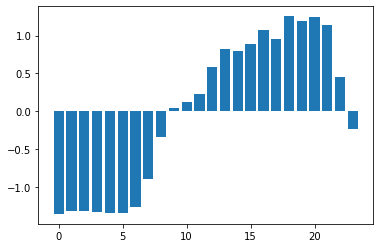

In [122]:
# bar graph
plt.bar(dfTrim.index, dfTrim['traffic_diff_zscore'])
plt.show()

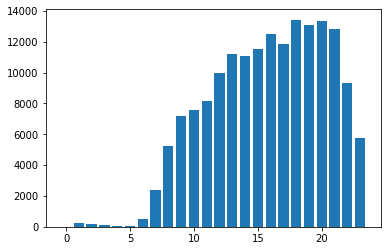

In [123]:
# bar graph
plt.bar(dfTrim.index, dfTrim['traffic_diff'])
plt.show()

<AxesSubplot: xlabel='index_hour', ylabel='day_name'>

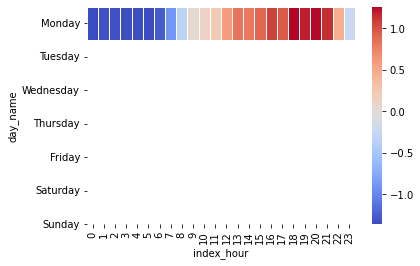

In [125]:
# create list of days
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# create list from 0 to 23
hours = list(range(0, 24))
# create heatmap with days as y-axis and hours as x-axis
dfTrim = dfTrim.pivot('day_name', 'index_hour', 'traffic_diff_zscore')
sns.heatmap(dfTrim, xticklabels=days, yticklabels=hours)

<AxesSubplot: xlabel='index_hour', ylabel='day_name'>

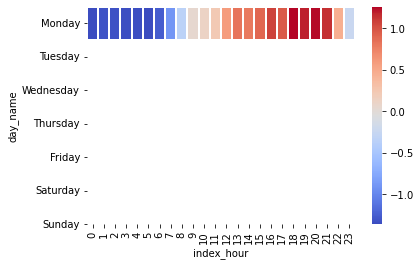

In [128]:
sns.heatmap(dfTrim, yticklabels=days, xticklabels=hours,linewidth = 2, cmap='coolwarm')